Import libraries required to do the preparation and exploration data.

In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import geopy.distance
from datetime import datetime
import warnings
warnings.filterwarnings("ignore") 

Defined function to access the database.

In [2]:
def get_result(query):
    """
    Parameters
    ==========
    query : str
            SQL query to access table from the database
            
    Returns
    ==========
    data : list
           table in the database
    
    """
    
    conn = sqlite3.connect("olist.db")
    cursor = conn.cursor()
    cursor.execute(query)
    data = cursor.fetchall()
    conn.close()
    return data

def create_df(data, columns):
    """
    Parameters
    ==========
    data : list
           table to transform in data frame
    
    columns : list
              header of table
            
    Returns
    ==========
    data in data frame format
    """
    
    return pd.DataFrame(data = data, columns = columns).drop(["index"], axis = 1)

In order to answer our questions, we need some tables from the database. First, we use data from the *olist_order_dataset* table.

In [3]:
orders = create_df(get_result("SELECT * FROM olist_order_dataset"),
                   [
                       
                       "index",
                       "order_id",
                       "customer_id",
                       "order_status",
                       "order_purchase_timestamp",
                       "order_approved_at",
                       "order_delivered_carrier_date",
                       "order_delivered_customer_date",
                       "order_estimated_delivery_date"
                   ])

In [4]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


After accessing the table, we will check the table info to know whether the data types have matched the data values.

In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


There are 99441 entries in the table with 8 columns. Some columns have null values and data types that don't match the values. 

*order_purchase_timestamp*, *order_approved_at*, *order_delivered_carrier_date*, *order_delivered_customer_date*, and *order_estimated_delivery_date* columns is supposed to be datetime data type. In order to fix that, we will change the data type.

In [6]:
date_type = ["order_purchase_timestamp", 
             "order_approved_at", 
             "order_delivered_carrier_date", 
             "order_delivered_customer_date",
             "order_estimated_delivery_date"]

orders[date_type] = pd.to_datetime(orders[date_type].stack()).unstack()

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


After that, we want to see how many missing values are in the data and what can we do to them.

In [7]:
missing_values = orders.isnull().sum()
percent_missing = orders.isnull().sum() * 100 / len(orders)
missing_value_orders = pd.DataFrame({"missing_values": missing_values,
                                     "percent_missing_values": round(percent_missing, 2)})

In [8]:
missing_value_orders

,missing_values,percent_missing_values
order_id,0,0.00
customer_id,0,0.00
order_status,0,0.00
order_purchase_timestamp,0,0.00
order_approved_at,160,0.16
order_delivered_carrier_date,1783,1.79
order_delivered_customer_date,2965,2.98
order_estimated_delivery_date,0,0.00


As we can see that the missing values are a quite bit compare to all the available data (less than 5%). But, we want to see what is the *order_status* for the missing values.

*order_status* for missing values in *order_approved_at* column:

In [9]:
orders[orders["order_approved_at"].isna()]["order_status"].value_counts()

canceled     141
delivered     14
created        5
Name: order_status, dtype: int64

For the missing value in the *order_approved_at* column, some data are canceled and still on created which makes sense that there's no data yet in the *order_approved_at* column because the orders haven't been approved or not approved.

And for the data with *order_status* delivered, we will check whether the other date (i.e. *order_delivered_carrier_date* and *order_delivered_customer_date*) are missing or not.

In [10]:
orders[(orders["order_approved_at"].isna()) & 
       (orders["order_status"] == "delivered")]\
[["order_delivered_carrier_date","order_delivered_customer_date"]].isna().sum()

order_delivered_carrier_date     0
order_delivered_customer_date    0
dtype: int64

Turns out, the other dates are all available which means there is an error system so that *order_approved_at* data are not recorded.

Next, we will see *order_status* for missing values in *order_delivered_carrier_date* columns:

In [11]:
orders[orders["order_delivered_carrier_date"].isna()]["order_status"].value_counts()

unavailable    609
canceled       550
invoiced       314
processing     301
created          5
delivered        2
approved         2
Name: order_status, dtype: int64

For missing values in this column, some data are canceled, some are in process (approved, invoiced, processing, created), some are not recorded (delivered), and some are unavailable.

So do the *order_delivered_customer_date* columns:

In [12]:
orders[orders["order_delivered_customer_date"].isna()]["order_status"].value_counts()

shipped        1107
canceled        619
unavailable     609
invoiced        314
processing      301
delivered         8
created           5
approved          2
Name: order_status, dtype: int64

Some data with missing values are canceled, some are in process (approved, invoiced, processing, created, shipped), some are not recorded (delivered), and some are unavailable.

After the exploration above, we will do nothing to the missing value and let them as they are. The missing values will be processed depending on the question that will be answered later.

Next, we will check if there are any duplicate data in the table.

In [13]:
orders.duplicated().sum()

0

There"s no duplicated data in the table.

Furthermore, we can use the data to answer the first questions.

**1. How is the number of orders trending each month??**

Specifically to answer this question, we must to exclude the data with *order_status* canceled because we only want to explore the data that have been approved. Order date is taken from *order_purchase_timestamp* column so in this case we only take 2 columns required i.e., *order_id* and *order_purchase_timestamp* columns.

In [14]:
orders_used = orders[orders["order_status"] != "canceled"][["order_id","order_purchase_timestamp"]].copy()

Down-sampling the data to see the number of orders each month.

In [15]:
figure_1 = orders_used.set_index("order_purchase_timestamp")\
                      .resample("M")\
                      .count()\
                      .reset_index()\
                      .rename(columns = {"order_purchase_timestamp":"order_purchase_date", "order_id":"count"})

In [16]:
figure_1.head()

,order_purchase_date,count
0,2016-09-30,2
1,2016-10-31,300
2,2016-11-30,0
3,2016-12-31,1
4,2017-01-31,797


The data above is visualized in the figure below:

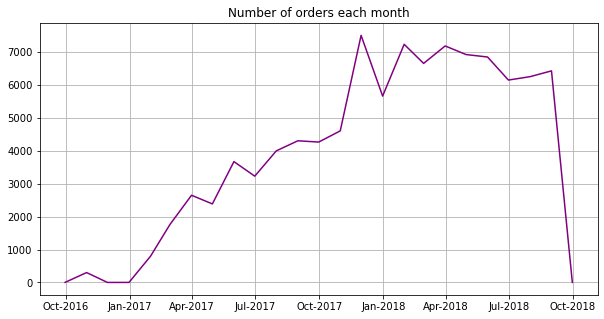

In [17]:
# format color and size figure
fig, ax = plt.subplots(facecolor = "#ffffff")
fig.set_size_inches(10,5)

# plot the data
ax.plot("order_purchase_date","count", data = figure_1, color = "purple")

# format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))

# show title
plt.title("Number of orders each month")

# show grid
plt.grid()

plt.show()

As we can see from the figure above, in lately 2016, the number of orders is not much, but increased from 2017 to 2018. In the last month, the number of orders dropped dramatically because the data is not recorded in a full month. Despite that, it's a good sign to our business that order activity increase steadily.

**2. How is the order activity by time and day?**

To answer this question, we can still use the same table as the question before. But in this case, we have to extract some features such as year, day, and hour of *order_purchase_timestamp* because we want to see at what day and time the customer frequently orders.

In [18]:
orders_used["order_purchase_year"] = orders_used["order_purchase_timestamp"].dt.year
orders_used["order_purchase_day"] = orders_used["order_purchase_timestamp"].dt.dayofweek
orders_used["order_purchase_hour"] = orders_used["order_purchase_timestamp"].dt.hour

Next, we pivot the data to see the number of orders each day and time in table format.

In [19]:
figure_2 = pd.pivot_table(orders_used[["order_id","order_purchase_year","order_purchase_day","order_purchase_hour"]], 
                          index = ["order_purchase_year","order_purchase_day"], 
                          columns = "order_purchase_hour", 
                          aggfunc = "count")

Formatting pivot table.

In [20]:
figure_2.columns = figure_2.columns.droplevel()
figure_2.columns = figure_2.columns.rename("hour")
figure_2.index = figure_2.index.rename(["year","day"])

In [21]:
figure_2

hour         0      1     2     3     4     5     6      7      8      9   \
year day                                                                    
2016 0      1.0    NaN   1.0   NaN   2.0   NaN   NaN    2.0    1.0    4.0   
     1      NaN    NaN   NaN   NaN   NaN   NaN   NaN    NaN    NaN    3.0   
     2      1.0    1.0   NaN   NaN   NaN   NaN   NaN    1.0    4.0    2.0   
     3      2.0    NaN   1.0   NaN   NaN   NaN   NaN    2.0    2.0    3.0   
     4      1.0    NaN   1.0   NaN   NaN   NaN   NaN    NaN    3.0    2.0   
     5      NaN    1.0   1.0   NaN   1.0   NaN   NaN    NaN    2.0    2.0   
     6      NaN    NaN   NaN   NaN   NaN   NaN   NaN    NaN    NaN    NaN   
2017 0    153.0   62.0  30.0  12.0   8.0   5.0  31.0   80.0  194.0  310.0   
     1    144.0   65.0  45.0  15.0  16.0  10.0  30.0   90.0  230.0  352.0   
     2    169.0   93.0  40.0  14.0  15.0  16.0  34.0   86.0  217.0  362.0   
     3    156.0   83.0  36.0  12.0  15.0  15.0  31.0   96.0  207.0  307.0   
     4    220.0  126.0  37.0  26.0  25.0  17.0  45.0   91.0  226.0  358.0   
     5    180.0   81.0  34.0  28.0  12.0  13.0  24.0   47.0  105.0  198.0   
     6    126.0   79.0  37.0  21.0  13.0  18.0  17.0   35.0   96.0  159.0   
2018 0    171.0   72.0  35.0  24.0  11.0  17.0  35.0   78.0  282.0  458.0   
     1    162.0   92.0  35.0  13.0  13.0  14.0  41.0  130.0  288.0  505.0   
     2    224.0   83.0  41.0  18.0  18.0  11.0  59.0  123.0  291.0  460.0   
     3    197.0   84.0  37.0  27.0  16.0  13.0  53.0  121.0  290.0  443.0   
     4    200.0   86.0  34.0  23.0  15.0  18.0  51.0  115.0  264.0  405.0   
     5    134.0   92.0  31.0  15.0  12.0  10.0  28.0   57.0  141.0  230.0   
     6    136.0   61.0  32.0  22.0  14.0   9.0  16.0   70.0  108.0  188.0   

hour      ...     14     15     16     17     18     19     20     21     22  \
year day  ...                                                                  
2016 0    ...    2.0    6.0    5.0    2.0    2.0    NaN    NaN    1.0    4.0   
     1    ...    4.0    7.0    6.0    2.0    3.0    4.0    1.0    4.0    4.0   
     2    ...    4.0    2.0    1.0    5.0    1.0    1.0    4.0    2.0    4.0   
     3    ...    2.0    2.0    4.0    3.0    3.0    2.0    3.0    NaN    3.0   
     4    ...    4.0    2.0    2.0    3.0    1.0    3.0    NaN    3.0    4.0   
     5    ...    2.0    4.0    1.0    2.0    2.0    NaN    3.0    4.0    4.0   
     6    ...    NaN    1.0    NaN    NaN    NaN    NaN    NaN    1.0    9.0   
2017 0    ...  478.0  474.0  475.0  422.0  400.0  413.0  440.0  510.0  470.0   
     1    ...  473.0  484.0  487.0  443.0  369.0  409.0  428.0  467.0  449.0   
     2    ...  452.0  443.0  453.0  409.0  380.0  359.0  409.0  423.0  362.0   
     3    ...  417.0  410.0  410.0  408.0  337.0  363.0  377.0  393.0  384.0   
     4    ...  464.0  442.0  433.0  377.0  353.0  411.0  340.0  383.0  375.0   
     5    ...  320.0  330.0  335.0  333.0  288.0  351.0  343.0  292.0  250.0   
     6    ...  317.0  335.0  352.0  375.0  389.0  406.0  430.0  378.0  399.0   
2018 0    ...  608.0  591.0  604.0  560.0  518.0  525.0  580.0  602.0  509.0   
     1    ...  639.0  544.0  584.0  519.0  499.0  505.0  547.0  549.0  505.0   
     2    ...  588.0  533.0  577.0  549.0  463.0  480.0  483.0  534.0  509.0   
     3    ...  553.0  510.0  657.0  487.0  438.0  457.0  454.0  445.0  466.0   
     4    ...  487.0  530.0  532.0  433.0  366.0  367.0  397.0  334.0  319.0   
     5    ...  351.0  386.0  358.0  360.0  420.0  399.0  381.0  357.0  290.0   
     6    ...  363.0  374.0  358.0  420.0  501.0  491.0  535.0  501.0  461.0   

hour         23  
year day         
2016 0      NaN  
     1      5.0  
     2      1.0  
     3      2.0  
     4      2.0  
     5      1.0  
     6      4.0  
2017 0    374.0  
     1    333.0  
     2    280.0  
     3    271.0  
     4    292.0  
     5    201.0  
     6    286.0  
2018 0    339.0  
     1    352.0  
     2    333.0  
     3    274.0  
     4    217.0  
     5   

Then, we visualized the pivot above as a heatmap graph.

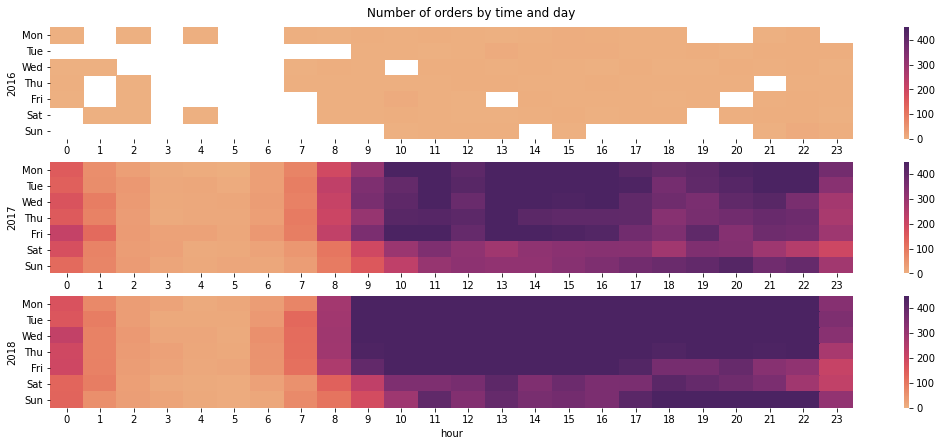

In [22]:
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (18, 7))

# name label of y axis
y_axis_labels = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"] 

fig.suptitle("Number of orders by time and day", x = 0.45, y = 0.92)

# figure for 2016 data
# plot the data
sns.heatmap(data = figure_2.loc[(2016)], 
            cmap = "flare",
            vmin = 0, vmax = 450,
            ax = ax[0])  
# formatting figure
ax[0].set(xlabel = None)
ax[0].set(ylabel = "2016")
ax[0].set_yticklabels(labels = y_axis_labels, rotation=0)

# figure for 2017 data
# plot the data
sns.heatmap(data = figure_2.loc[(2017)], 
            cmap = "flare", 
            vmin = 0, vmax = 450, 
            ax = ax[1])
# formatting figure
ax[1].set(xlabel = None)
ax[1].set(ylabel = "2017")
ax[1].set_yticklabels(labels = y_axis_labels, rotation=0)

# figure for 2018 data
# plot the data
sns.heatmap(data = figure_2.loc[(2018)], 
            cmap = "flare", 
            vmin=0, vmax=450, 
            ax = ax[2])
# formatting figure
ax[2].set(ylabel = "2018")
ax[2].set_yticklabels(labels = y_axis_labels, rotation=0)

plt.show()

Based on the figure above, customers frequently order between 10 AM to 10 PM on weekdays. In that time interval, the number of orders is between 200 to 400 orders. Outside of that time, the order activity is a quite bit. In terms of business, we can do a midnight or weekend flash-sale program to increase order activity in that time period.

**3. How is the delivery time trending each month?**

In this question, we still use the orders table, but to measure the delivery time we need 2 columns i.e., *order_delivered_carrier_date* and *order_delivered_customer_date* column. 

As we can see before the *order_delivered_carrier_date* and *order_delivered_customer_date* columns have missing values. Because it is datetime data type, we can't easily fill the data and the easiest way to handle this is to drop the data.

In [23]:
orders_used_2 = orders[["order_id",
                        "order_delivered_carrier_date",
                        "order_delivered_customer_date"]].dropna(subset = ["order_delivered_carrier_date",
                                                                           "order_delivered_customer_date"]).copy()

In [24]:
orders_used_2.head()

,order_id,order_delivered_carrier_date,order_delivered_customer_date
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-04 19:55:00,2017-10-10 21:25:13
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-26 14:31:00,2018-08-07 15:27:45
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 13:50:00,2018-08-17 18:06:29
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-22 13:39:59,2017-12-02 00:28:42
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-14 19:46:34,2018-02-16 18:17:02


Next, we measure the delivery time by substracted *order_delivered_carrier_date* from *order_delivered_customer_date*. The result is in days.

In [25]:
orders_used_2["delivery_time (days)"] = (orders_used_2["order_delivered_customer_date"].dt.date - \
                                         orders_used_2["order_delivered_carrier_date"].dt.date).astype("timedelta64[D]")

Here we want to see if there are any outliers in the *delivery_time (days)* column.

In [26]:
orders_used_2["delivery_time (days)"].describe()

count    96475.000000
mean         9.282778
std          8.777229
min        -16.000000
25%          4.000000
50%          7.000000
75%         12.000000
max        205.000000
Name: delivery_time (days), dtype: float64

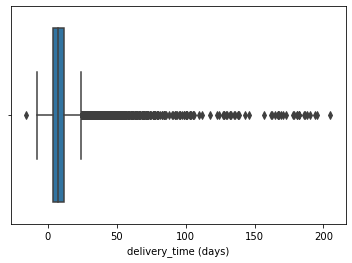

In [27]:
sns.boxplot(data = orders_used_2, x = "delivery_time (days)")
plt.show()

From the descriptive statistics and the boxplot, on the left (small value) there are negative values that are very strange because time won't be negative. And on the right (big value) there are many values that are far enough from the other common values that are very strange too because it is almost impossible to have many deliveries for months. So, to handle the outliers in this case, we want to replace the extreme values with its 0.99 percentile.

Before that, we defined a function to handle the outliers.

In [28]:
def handle_outliers(data, col, method):
    
    lower_bound = 0
    upper_bound = data[col].quantile(0.99)
    
    if method == "filter":
        data = data[(data[col] >= lower_bound) & (data[col] < upper_bound)]
        return data

    elif method == "imputation":
        data = data[data[col] >= lower_bound]
        data.loc[data[col] > upper_bound, col] = upper_bound
        return data

In [29]:
orders_used_2 = handle_outliers(orders_used_2, "delivery_time (days)", "imputation")

Re-check the statistic descriptive and outliers of the data.

In [30]:
orders_used_2["delivery_time (days)"].describe()

count    96455.000000
mean         9.123197
std          7.575986
min          0.000000
25%          4.000000
50%          7.000000
75%         12.000000
max         41.000000
Name: delivery_time (days), dtype: float64

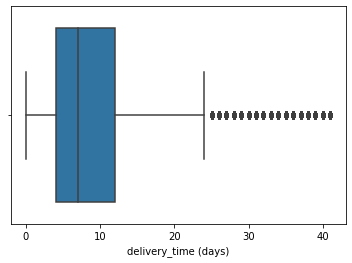

In [31]:
sns.boxplot(data =orders_used_2, x = "delivery_time (days)")
plt.show()

From the figure above, there's still any outlier in the data but not too far from the common values.

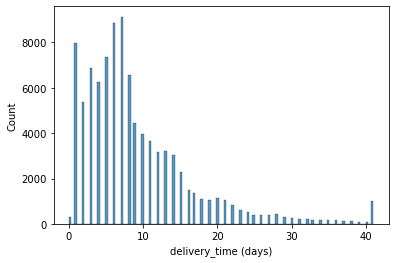

In [32]:
sns.histplot(data = orders_used_2, x = "delivery_time (days)")
plt.show()

Here's the histogram of the *delivery_time (days)* column. From the figure above, we can decide what statistics measurement is used to determine the average delivery time. Because the distribution is skewed, the best measurement to represent the average delivery time is the median. Hence, we need to down-sampling the data by the *order_delivered_carrier_date* column.

In [33]:
figure_3 = orders_used_2.set_index("order_delivered_carrier_date")\
                        .resample("M")\
                        .median()\
                        .reset_index()

In [34]:
figure_3.head()

,order_delivered_carrier_date,delivery_time (days)
0,2016-10-31,3.0
1,2016-11-30,7.0
2,2016-12-31,3.5
3,2017-01-31,7.0
4,2017-02-28,7.0


The data above is visualized in the figure below:

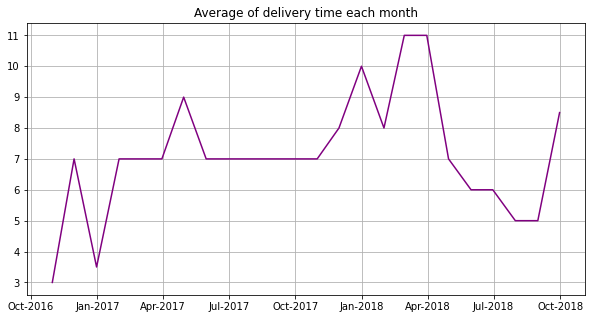

In [35]:
# format color and size figure
fig, ax = plt.subplots(facecolor = "#ffffff")
fig.set_size_inches(10,5)

# plot the data
ax.plot("order_delivered_carrier_date", "delivery_time (days)", data = figure_3, color = "purple")

# format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))

# show title
plt.title("Average of delivery time each month")

# show grid
plt.grid()

plt.show()

From the figure above, the delivery time tends to be consistent over months with the average between 6 and 8 days per order.

**4. Whether the number of orders each month affect the delivery time?**

For this question, we will use aggregating results from question number 1 and question number 3 by joining the tables to see the correlation between the two variables (which is the number of orders and delivery time).

In [36]:
figure_4 = pd.concat([figure_1.set_index("order_purchase_date"), 
                      figure_3.set_index("order_delivered_carrier_date")], axis = 1, join = "outer")

figure_4 = figure_4.rename(columns = {"count":"number_orders"})

In [37]:
figure_4.head(10)

,number_orders,delivery_time (days)
2016-09-30,2,NaN
2016-10-31,300,3.0
2016-11-30,0,7.0
2016-12-31,1,3.5
2017-01-31,797,7.0
2017-02-28,1763,7.0
2017-03-31,2649,7.0
2017-04-30,2386,9.0
2017-05-31,3671,7.0
2017-06-30,3229,7.0


Then, measure the correlation between *number_orders* and *delivery_time (days)*.

In [38]:
corr_figure_4 = figure_4.corr()

The correlation is visualized below:

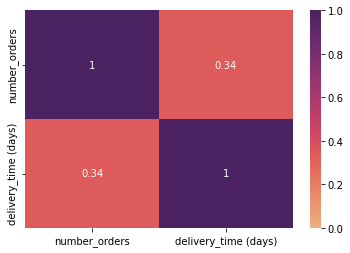

In [39]:
# plot the data correlation
sns.heatmap(corr_figure_4, annot = True, cmap = "flare", vmin = 0, vmax = 1)

# format y-axis
plt.yticks(va = "center")

plt.show()

Based on the figure above, the coefficient correlation between *number_orders* and *delivery_time (days)* is 0.34, which means the two variables have a weak correlation. But… if we look at the table below:

In [40]:
figure_4

,number_orders,delivery_time (days)
2016-09-30,2,NaN
2016-10-31,300,3.0
2016-11-30,0,7.0
2016-12-31,1,3.5
2017-01-31,797,7.0
2017-02-28,1763,7.0
2017-03-31,2649,7.0
2017-04-30,2386,9.0
2017-05-31,3671,7.0
2017-06-30,3229,7.0


There are values of number_orders that are extremely different from the others that can be caused by incomplete data. So that we will re-calculate the correlation with filtered data.

In [41]:
figure_4_filtered = figure_4.loc["2017-01-31":"2018-08-31"]
corr_figure_4_filtered = figure_4_filtered.corr()

The correlation of filtered data is visualized below:

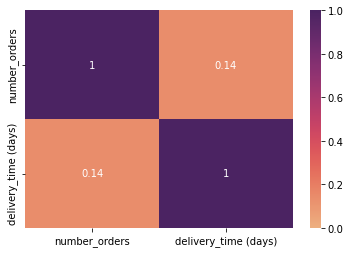

In [42]:
# plot the data correlation
sns.heatmap(corr_figure_4_filtered, annot = True, cmap = "flare", vmin = 0, vmax = 1)

# format y-axis
plt.yticks(va = "center")

plt.show()

After the filtration, the coefficient correlation decreased significantly from the previous 0.34 to 0.14. The *number_orders* and *delivery_time (days)* columns have a weak correlation before but now have a negligible correlation.

<img src="Interpretation of Correlation Coefficients.jpeg" width="400">

Source: [Interpretation of the Correlation Coefficient](https://journals.lww.com/anesthesia-analgesia/fulltext/2018/05000/correlation_coefficients__appropriate_use_and.50.aspx)

**5. Whether the distance between the seller and the customer affect the delivery time?**

In order to answer this question, we have to know the seller and customer's location. So, in this case, we access the *olist_geolocation_dataset* table.

In [43]:
geolocation = create_df(get_result("SELECT * FROM olist_geolocation_dataset"),
                        [
                            "index",
                            "geolocation_zip_code_prefix",
                            "geolocation_lat",
                            "geolocation_lng",
                            "geolocation_city",
                            "geolocation_state"
                        ])

In [44]:
geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


After access the table, we will check the table info.

In [45]:
geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In the table, there are 1000163 entries, and seems like there's no null value in the table. But, the *geolocation_zip_code_prefix* is more suitable to be an object data type.

In [46]:
geolocation["geolocation_zip_code_prefix"] = geolocation["geolocation_zip_code_prefix"].astype("object")

geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  object 
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), object(3)
memory usage: 38.2+ MB


Then, we will check for the string values is there any inconsistency in the data. First, we will find unique value for the *geolocation_city* column.

In [47]:
geolocation["geolocation_city"].unique()

array(['sao paulo', 'são paulo', 'sao bernardo do campo', ..., 'ciríaco',
       'estação', 'vila lângaro'], dtype=object)

Seems like there are inconsistencies in the *geolocation_city* column, can be seen from the city "sao paulo" and "são paulo" are inconsistent in the letter "a".

To fix this problem we define two functions, the first function is to extract every single letter or character in the column.

In [48]:
def uniq(to_search):
    """
    Parameters
    ==========
    to_search : Series
                data that want to be extract
            
    Returns
    ==========
    data : set
           unique character in the to_search Series
    """
    
    uniq_char = set()
    
    for i in to_search.unique():
        if i is None:
            continue
        else:
            for j in i.split():
                for k in j.split()[0]:
                    uniq_char.add(k)
                
    print(uniq_char)

With this function, we can see every unique single letter and character in the *geolocation_city* column and find the inconsistency.

In [49]:
uniq(geolocation["geolocation_city"])

{'p', 'ó', 'r', '³', 'ô', 't', ')', 'e', '6', 'f', 's', 'k', 'n', '.', 'í', 'i', 'g', "'", 'ü', ',', '´', '£', '&', 'o', '*', 'q', 'h', 'õ', 'j', 'é', 'z', 'â', '3', 'º', 'c', '1', '-', 'd', '(', 'b', 'x', 'l', 'w', 'ã', '`', 'ú', 'v', 'm', 'ç', 'a', '2', 'ê', 'á', 'y', '4', '%', 'u', ';'}


After that, we assign a dictionary that stores the inconsistent or strange characters and the replacement.

In [50]:
replaced_char = {"ã":"a",
                 "á":"a",
                 "â":"a",
                 "ç":"c",
                 "é":"e",
                 "ê":"e",
                 "í":"i",
                 "ó":"o",
                 "õ":"o",
                 "ô":"o",
                 "ü":"u",
                 "ú":"u",
                 "-":" ",
                 "`":"",
                 "´":"",
                 ",":"",
                 "%":"",
                 "'":"",
                 "*":"",
                 "&":"",
                 ";":"",
                 "º":"",
                 "(":"",
                 ")":"",
                 "³":"",
                 ".":"",
                 "£":"",
                 "1":"",
                 "2":"",
                 "3":"",
                 "4":"",
                 "6":""
                }

The second function below is defined as a function to replace the character in the column.

In [51]:
def fix_char(replaced_char, to_fix):
    """
    Parameters
    ==========
    replaced_char : dictionary
                    consist of character that want to replaced and the replacement
    
    to_fix : Series
             data that want to replace
            
    """
    for old_char, new_char in replaced_char.items():
        to_fix = to_fix.str.replace(old_char, new_char, regex = True)
    
    return to_fix

With applied the function above, we replace the character in the *geolocation_city* column with the character assign in the *replaced_char*.

In [52]:
geolocation.loc[:,"geolocation_city"] = fix_char(replaced_char, geolocation["geolocation_city"])

After replacing the inconsistent character, then re-check the column character.

In [53]:
uniq(geolocation["geolocation_city"])

{'p', 'r', 't', 'e', 'f', 's', 'k', 'n', 'i', 'g', 'o', 'q', 'h', 'j', 'z', 'c', 'd', 'b', 'x', 'l', 'w', 'v', 'm', 'a', 'y', 'u'}


Now, the characters have been consistent.

We will do the same process with *geolocation_state* column.

In [54]:
uniq(geolocation["geolocation_state"])

{'E', 'D', 'I', 'J', 'O', 'P', 'T', 'S', 'L', 'M', 'F', 'B', 'G', 'N', 'C', 'R', 'A'}


The values have been consistent already.

After fixing the inconsistency, we want to check if there are any duplicate data in the table.

In [55]:
geolocation.duplicated().sum()

279749

Turns out, there are 279749 duplicate data and we will only keep one data and drop the others.

In [56]:
geolocation = geolocation.drop_duplicates(keep = "first")

As a primary key, we want the *geolocation_zip_code_prefix*, *geolocation_city*, and *geolocation_state* columns to be unique to determine seller and customer location (latitude and longitude). But, as we see below, some combinations of the three columns have different latitude and longitude.

In [57]:
geolocation[["geolocation_zip_code_prefix",
             "geolocation_city",
             "geolocation_state"]].value_counts()

geolocation_zip_code_prefix  geolocation_city      geolocation_state
38400                        uberlandia            MG                   746
11680                        ubatuba               SP                   727
35500                        divinopolis           MG                   726
11740                        itanhaem              SP                   666
36400                        conselheiro lafaiete  MG                   627
                                                                       ... 
72460                        brasilia              DF                     1
13381                        nova odessa           SP                     1
58291                        curral de cima        PB                     1
45996                        teixeira de freitas   BA                     1
13507                        rio claro             SP                     1
Length: 19561, dtype: int64

To fix that, we decide to determine the latitude and longitude with the average of each of them grouped by *geolocation_zip_code_prefix*, *geolocation_city*, and *geolocation_state*.

In [58]:
geo_index = ["geolocation_zip_code_prefix","geolocation_city","geolocation_state"]
geolocation = geolocation.groupby(geo_index).mean().reset_index()

In [59]:
geolocation.head()

,geolocation_zip_code_prefix,geolocation_city,geolocation_state,geolocation_lat,geolocation_lng
0,1001,sao paulo,SP,-23.550271,-46.634047
1,1002,sao paulo,SP,-23.547657,-46.634991
2,1003,sao paulo,SP,-23.548991,-46.635653
3,1004,sao paulo,SP,-23.549829,-46.634792
4,1005,sao paulo,SP,-23.549487,-46.636650


Re-check the counts of each location.

In [60]:
geolocation[["geolocation_zip_code_prefix",
             "geolocation_city",
             "geolocation_state"]].value_counts()

geolocation_zip_code_prefix  geolocation_city     geolocation_state
1001                         sao paulo            SP                   1
62320                        tiangua              CE                   1
62380                        guaraciaba do norte  CE                   1
62375                        carnaubal            CE                   1
62370                        sao benedito         CE                   1
                                                                      ..
20785                        rio de janeiro       RJ                   1
20780                        rio de janeiro       RJ                   1
20776                        rio de janeiro       RJ                   1
20775                        rio de janeiro       RJ                   1
99990                        muliterno            RS                   1
Length: 19561, dtype: int64

Finally, each location only has 1 latitude and 1 longitude.

Next, we re-access the database to get the seller's location for each order. In order to do that, we have to join some tables such as *olist_order_dataset*, *olist_order_items_dataset*, and *olist_sellers_dataset* using their primary and foreign key. We don't access all columns, but only the columns required.

In [61]:
seller = create_df(get_result("SELECT 0,\
                                      order_id,\
                                      order_delivered_carrier_date,\
                                      order_delivered_customer_date,\
                                      seller_id,\
                                      seller_zip_code_prefix,\
                                      seller_city,\
                                      seller_state\
                              FROM olist_order_dataset\
                              LEFT JOIN olist_order_items_dataset USING(order_id)\
                              LEFT JOIN olist_sellers_dataset USING(seller_id)"),
                   [
                       "index",
                       "order_id",
                       "order_delivered_carrier_date",
                       "order_delivered_customer_date",
                       "seller_id",
                       "seller_zip_code_prefix",
                       "seller_city",
                       "seller_state"
                   ])

In [62]:
seller.head()

,order_id,order_delivered_carrier_date,order_delivered_customer_date,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-04 19:55:00,2017-10-10 21:25:13,3504c0cb71d7fa48d967e0e4c94d59d9,9350.0,maua,SP
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-26 14:31:00,2018-08-07 15:27:45,289cdb325fb7e7f891c38608bf9e0962,31570.0,belo horizonte,SP
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 13:50:00,2018-08-17 18:06:29,4869f7a5dfa277a7dca6462dcf3b52b2,14840.0,guariba,SP
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-22 13:39:59,2017-12-02 00:28:42,66922902710d126a0e7d26b0e3805106,31842.0,belo horizonte,MG
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-14 19:46:34,2018-02-16 18:17:02,2c9e548be18521d1c43cde1c582c6de8,8752.0,mogi das cruzes,SP


Because *olist_order_items_dataset* is an order detail for each order in *olist_order_dataset*, we expect there are duplicated data in the data we access.

In [63]:
seller.duplicated().sum()

12640

As our expectation, there are 12640 duplicates data, we'll drop them and only keep one data in the table.

In [64]:
seller = seller.drop_duplicates(keep = "first")

In [65]:
seller.head()

,order_id,order_delivered_carrier_date,order_delivered_customer_date,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-04 19:55:00,2017-10-10 21:25:13,3504c0cb71d7fa48d967e0e4c94d59d9,9350.0,maua,SP
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-26 14:31:00,2018-08-07 15:27:45,289cdb325fb7e7f891c38608bf9e0962,31570.0,belo horizonte,SP
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 13:50:00,2018-08-17 18:06:29,4869f7a5dfa277a7dca6462dcf3b52b2,14840.0,guariba,SP
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-22 13:39:59,2017-12-02 00:28:42,66922902710d126a0e7d26b0e3805106,31842.0,belo horizonte,MG
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-14 19:46:34,2018-02-16 18:17:02,2c9e548be18521d1c43cde1c582c6de8,8752.0,mogi das cruzes,SP


Next, we want to see the *seller* table info.

In [66]:
seller.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100785 entries, 0 to 113424
Data columns (total 7 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       100785 non-null  object 
 1   order_delivered_carrier_date   99001 non-null   object 
 2   order_delivered_customer_date  97817 non-null   object 
 3   seller_id                      100010 non-null  object 
 4   seller_zip_code_prefix         100010 non-null  float64
 5   seller_city                    100010 non-null  object 
 6   seller_state                   100010 non-null  object 
dtypes: float64(1), object(6)
memory usage: 6.2+ MB


There are 100785 entries with 7 columns. Some columns seem like have missing values and don't match the data type.

First, we want to fix the data type. The missing values will be done at the end of the cleaning process.

In [67]:
date_type = ["order_delivered_carrier_date",
              "order_delivered_customer_date"]
seller[date_type] = pd.to_datetime(seller[date_type].stack()).unstack()

seller = seller.astype({"seller_zip_code_prefix": "object"})

seller.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100785 entries, 0 to 113424
Data columns (total 7 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       100785 non-null  object        
 1   order_delivered_carrier_date   99001 non-null   datetime64[ns]
 2   order_delivered_customer_date  97817 non-null   datetime64[ns]
 3   seller_id                      100010 non-null  object        
 4   seller_zip_code_prefix         100010 non-null  object        
 5   seller_city                    100010 non-null  object        
 6   seller_state                   100010 non-null  object        
dtypes: datetime64[ns](2), object(5)
memory usage: 8.2+ MB


Next, find out if there are any inconsistencies in the seller_city column.

In [68]:
uniq(seller["seller_city"])

{'p', 'r', '̃', '.', 't', ')', 'e', 'f', 's', 'n', 'i', 'g', "'", ',', '´', 'o', 'q', '5', 'h', 'z', 'j', '/', '0', '8', 'c', '\\', '@', '-', 'd', '(', 'b', 'x', 'l', 'v', 'm', 'a', '2', 'y', '4', 'u'}


Assign a dictionary required to fix the inconsistent and strange character.

In [69]:
replaced_char = {")":"",
                 "(":"",
                 "\\":"",
                 "/":"",
                 "'":"",
                 ".":"",
                  "@":"",
                 "̃":"",
                 "´":"",
                 "0":"",
                 ",":"",
                 "2":"",
                 "4":"",
                 "5":"",
                 "8":"",
                 "-":"",
                 "riberao":"ribeirao",  # here to below is replaced to match state in the geolocation table
                 "santo andresao paulo":"santo andre",
                 "sando andre":"santo andre",
                 "s jose do rio preto":"sao jose do rio preto",
                 "sao paulo  sp":"sao paulo",
                 "scao jose do rio pardo":"sao jose do rio pardo",
                 "ribeirao preto  sao paulo":"ribeirao preto"
                }

Then, replace and fix the character in the *seller_city* column.

In [70]:
seller.loc[:,"seller_city"] = fix_char(replaced_char, seller["seller_city"])

Re-check is there still inconsistent or strange character in the column.

In [71]:
uniq(seller["seller_city"])

{'p', 'r', 't', 'e', 'f', 's', 'n', 'i', 'g', 'o', 'q', 'h', 'z', 'j', 'c', 'd', 'b', 'x', 'l', 'v', 'm', 'a', 'y', 'u'}


Do the same with *seller_state* column.

In [72]:
uniq(seller["seller_state"])

{'E', 'D', 'I', 'J', 'O', 'P', 'T', 'S', 'M', 'F', 'B', 'G', 'N', 'C', 'R', 'A'}


*seller_city* and *seller_state* values have been fixed and consistent.

Then, to know the latitude and longitude of each seller, we have to merge *seller* table with *geolocation* table on *zip_code_prefix*, *city*, and *state* in both tables.

In [73]:
seller_location = pd.merge(seller, 
                           geolocation,  
                           how="left", 
                           left_on=["seller_zip_code_prefix","seller_city", "seller_state"], 
                           right_on = ["geolocation_zip_code_prefix","geolocation_city", "geolocation_state"])

In [74]:
seller_location.head()

,order_id,order_delivered_carrier_date,order_delivered_customer_date,seller_id,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix,geolocation_city,geolocation_state,geolocation_lat,geolocation_lng
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-04 19:55:00,2017-10-10 21:25:13,3504c0cb71d7fa48d967e0e4c94d59d9,9350.0,maua,SP,9350.0,maua,SP,-23.680884,-46.444255
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-26 14:31:00,2018-08-07 15:27:45,289cdb325fb7e7f891c38608bf9e0962,31570.0,belo horizonte,SP,NaN,NaN,NaN,NaN,NaN
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 13:50:00,2018-08-17 18:06:29,4869f7a5dfa277a7dca6462dcf3b52b2,14840.0,guariba,SP,14840.0,guariba,SP,-21.363473,-48.229588
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-22 13:39:59,2017-12-02 00:28:42,66922902710d126a0e7d26b0e3805106,31842.0,belo horizonte,MG,31842.0,belo horizonte,MG,-19.836871,-43.923241
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-14 19:46:34,2018-02-16 18:17:02,2c9e548be18521d1c43cde1c582c6de8,8752.0,mogi das cruzes,SP,8752.0,mogi das cruzes,SP,-23.541525,-46.262148


Next, we will format the table to be more convenient by filtering some unrequired columns and renaming the column name.

In [75]:
seller_location = seller_location[["order_id",
                                   "order_delivered_carrier_date",
                                   "order_delivered_customer_date",
                                   "geolocation_lat",
                                   "geolocation_lng"]]

seller_location = seller_location.rename(columns = {"geolocation_lat":"seller_lat",
                                                    "geolocation_lng":"seller_lng"})

Now move on to customer data and do the same process.

In [76]:
customer = create_df(get_result("SELECT 0,\
                                        order_id,\
                                        order_delivered_carrier_date,\
                                        order_delivered_customer_date,\
                                        customer_id,\
                                        customer_zip_code_prefix,\
                                        customer_city,\
                                        customer_state\
                                FROM olist_order_dataset\
                                JOIN olist_order_customer_dataset USING(customer_id)"),
                                [
                                    "index",
                                    "order_id",
                                    "order_delivered_carrier_date",
                                    "order_delivered_customer_date",
                                    "customer_id",
                                    "customer_zip_code_prefix",
                                    "customer_city",
                                    "customer_state"
                                ])

In [77]:
customer.head()

,order_id,order_delivered_carrier_date,order_delivered_customer_date,customer_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-04 19:55:00,2017-10-10 21:25:13,9ef432eb6251297304e76186b10a928d,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-26 14:31:00,2018-08-07 15:27:45,b0830fb4747a6c6d20dea0b8c802d7ef,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 13:50:00,2018-08-17 18:06:29,41ce2a54c0b03bf3443c3d931a367089,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-22 13:39:59,2017-12-02 00:28:42,f88197465ea7920adcdbec7375364d82,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-14 19:46:34,2018-02-16 18:17:02,8ab97904e6daea8866dbdbc4fb7aad2c,9195,santo andre,SP


As we did with the *seller* table, we want to check if there any duplicated data in *customer* table.

In [78]:
customer.duplicated().sum()

0

Turns out there are no duplicated data.

Check customer information to see if there are any missing values and unmatched data types.

In [79]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   order_delivered_carrier_date   97658 non-null  object
 2   order_delivered_customer_date  96476 non-null  object
 3   customer_id                    99441 non-null  object
 4   customer_zip_code_prefix       99441 non-null  int64 
 5   customer_city                  99441 non-null  object
 6   customer_state                 99441 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


There are 99441 entries with 7 columns. Some columns seem like have missing values and don't matched data type.

First, we want to fix the data type.

In [80]:
date_type = ["order_delivered_carrier_date",
             "order_delivered_customer_date"]
customer[date_type] = pd.to_datetime(customer[date_type].stack()).unstack()

customer = customer.astype({"customer_zip_code_prefix": "object"})

customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 2   order_delivered_customer_date  96476 non-null  datetime64[ns]
 3   customer_id                    99441 non-null  object        
 4   customer_zip_code_prefix       99441 non-null  object        
 5   customer_city                  99441 non-null  object        
 6   customer_state                 99441 non-null  object        
dtypes: datetime64[ns](2), object(5)
memory usage: 5.3+ MB


Next, find out if there are inconsistencies in the customer_city column.

In [81]:
uniq(customer["customer_city"])

{'p', 'r', 't', 'e', '1', 'f', 's', 'k', 'n', 'i', 'g', "'", 'o', 'q', 'h', 'z', 'j', 'c', '-', 'd', 'b', 'x', 'l', 'w', 'v', 'm', 'a', 'y', '4', 'u'}


Assign a dictionary required to fix the inconsistent and strange characters.

In [83]:
replaced_char = {"1":"",
                 "4":"",
                 "-":"",
                 "'":""
                }

Then, replace and fix the character in the *customer_city* column.

In [84]:
customer.loc[:,"customer_city"] = fix_char(replaced_char, customer["customer_city"])

Re-check if is there still an inconsistent or strange character in the column.

In [85]:
uniq(customer["customer_city"])

{'p', 'r', 't', 'e', 'f', 's', 'k', 'n', 'i', 'g', 'o', 'q', 'h', 'z', 'j', 'c', 'd', 'b', 'x', 'l', 'w', 'v', 'm', 'a', 'y', 'u'}


Do the same with the *customer_state* column.

In [86]:
uniq(customer["customer_state"])

{'E', 'D', 'I', 'J', 'O', 'P', 'T', 'S', 'L', 'M', 'F', 'B', 'G', 'N', 'C', 'R', 'A'}


*customer_city* and *customer_state* values have been fixed and consistent.

Then, to know the latitude and longitude of each customer, we have to merge the *customer* table with the *geolocation* table on *zip_code_prefix*, *city*, and *state* in both tables.

In [87]:
customer_location = pd.merge(customer, 
                             geolocation,
                             how="left",
                             left_on=["customer_zip_code_prefix","customer_city", "customer_state"],
                             right_on = ["geolocation_zip_code_prefix","geolocation_city", "geolocation_state"])

In [88]:
customer_location.head()

,order_id,order_delivered_carrier_date,order_delivered_customer_date,customer_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix,geolocation_city,geolocation_state,geolocation_lat,geolocation_lng
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-04 19:55:00,2017-10-10 21:25:13,9ef432eb6251297304e76186b10a928d,3149,sao paulo,SP,3149.0,sao paulo,SP,-23.577622,-46.587055
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-26 14:31:00,2018-08-07 15:27:45,b0830fb4747a6c6d20dea0b8c802d7ef,47813,barreiras,BA,47813.0,barreiras,BA,-12.186877,-44.540232
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 13:50:00,2018-08-17 18:06:29,41ce2a54c0b03bf3443c3d931a367089,75265,vianopolis,GO,75265.0,vianopolis,GO,-16.745100,-48.514790
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-22 13:39:59,2017-12-02 00:28:42,f88197465ea7920adcdbec7375364d82,59296,sao goncalo do amarante,RN,59296.0,sao goncalo do amarante,RN,-5.774002,-35.270976
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-14 19:46:34,2018-02-16 18:17:02,8ab97904e6daea8866dbdbc4fb7aad2c,9195,santo andre,SP,9195.0,santo andre,SP,-23.676304,-46.514591


Next, we will format the table to be more convenient by filtering some unrequired columns and renaming the column name.

In [89]:
customer_location = customer_location[["order_id",
                                       "order_delivered_carrier_date",
                                       "order_delivered_customer_date",
                                       "geolocation_lat",
                                       "geolocation_lng"]]

customer_location = customer_location.rename(columns = {"geolocation_lat":"customer_lat",
                                                        "geolocation_lng":"customer_lng"})

We are almost there! Then, join the seller table and customer table to calculate the distance between the seller and the customer later.

In [90]:
figure_5 = pd.merge(customer_location, 
                    seller_location,  
                    how="left", 
                    left_on=["order_id","order_delivered_carrier_date","order_delivered_customer_date"], 
                    right_on = ["order_id","order_delivered_carrier_date","order_delivered_customer_date"])

As we said before, the last part of the cleaning process is to handle missing values.

In [91]:
figure_5.isna().sum()

order_id                            0
order_delivered_carrier_date     1784
order_delivered_customer_date    2968
customer_lat                      480
customer_lng                      480
seller_lat                       2427
seller_lng                       2427
dtype: int64

Almost all columns have missing values. We want to drop all rows with at least 1 missing value, but before that, we have to know what percentage of data to drop. If the data we want to drop is pretty much compared to all the data, we have to try another method to handle the missing value instead of dropping the data.

In [92]:
missing_value = figure_5.isna().any(axis = 1).sum()

print(f"Missing value percentage : {missing_value / len(figure_5) * 100:.2f}%")

Missing value percentage : 4.99%


Because the missing value in the data is less than 5%, hence we can drop the data.


*Generally, if less than 5% of values are missing then it is acceptable to ignore them. (source: [Working with Missing Data](https://pressbooks.library.upei.ca/montelpare/chapter/working-with-missing-data/#:~:text=Generally%2C%20if%20less%20than%205,to%20which%20data%20is%20missing.))*

In [93]:
figure_5 = figure_5.dropna()

After that, calculate delivery time by substracted *order_delivered_carrier_date* column from the *order_delivered_customer_date* column.

In [94]:
figure_5["delivery_time (days)"] = (figure_5["order_delivered_customer_date"].dt.date - \
                                    figure_5["order_delivered_carrier_date"].dt.date).astype("timedelta64[D]")

Next, we have to define a function to calculate distance between seller and customer.

In [95]:
def distancer(row):
    """
    Parameters
    ==========
    row : row that have 2 latitude and 2 longitude to measure
    """
    
    coords_1 = (row["seller_lat"], row["seller_lng"])
    coords_2 = (row["customer_lat"], row["customer_lng"])
    return geopy.distance.geodesic(coords_1, coords_2).km

Then, apply the function to calculate the distance.

In [96]:
figure_5["distance (km)"] = figure_5.apply(distancer, axis = 1)

As we did before, we'll check if there any outlier in the data.

In [97]:
figure_5[["delivery_time (days)", "distance (km)"]].describe()

,delivery_time (days),distance (km)
count,95753.000000,95753.000000
mean,9.244295,599.326944
std,8.754828,591.339735
min,-16.000000,0.000000
25%,4.000000,187.814888
50%,7.000000,433.630787
75%,12.000000,797.168727
max,205.000000,8652.113516


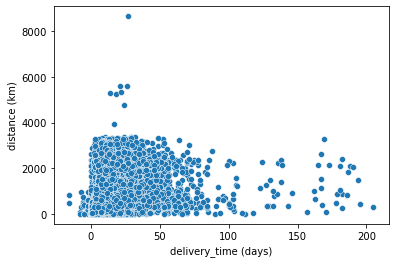

In [98]:
sns.scatterplot(x = figure_5["delivery_time (days)"], y = figure_5["distance (km)"])
plt.show()

Okay, we'll explain for the two variables above:

For the *delivery_time (days)* columns, as explained before, the negative values and big values in this data are so strange. So, to handle the outliers in this case, we have to filter the negative values and replace the extreme values with their 0.99 percentile.

For the *distance (km)* column, as we can see in the statistics descriptive, the 75th distance value (Q3) is far enough from the maximum value. As well as from the scatterplot there are values that are far enough from the other common values. It means there are outliers and we have to handle them. If we see from the measurement, there's no problem with the small values, so we"ll only filter the big values. Because a long-distance delivery is very likely to happen in the delivery, we won't replace the outliers, instead we will drop them so that these values don't affect the representation of overall values.

In [99]:
figure_5 = handle_outliers(figure_5, "delivery_time (days)", "imputation")

In [100]:
figure_5 = handle_outliers(figure_5, "distance (km)", "filter")

Re-check the statistic descriptive and outliers of the data.

In [101]:
figure_5[["delivery_time (days)", "distance (km)"]].describe()

,delivery_time (days),distance (km)
count,94759.000000,94759.000000
mean,8.989827,577.696964
std,7.470404,552.177887
min,0.000000,0.000000
25%,4.000000,181.558688
50%,7.000000,428.127540
75%,12.000000,780.117066
max,41.000000,2472.957027


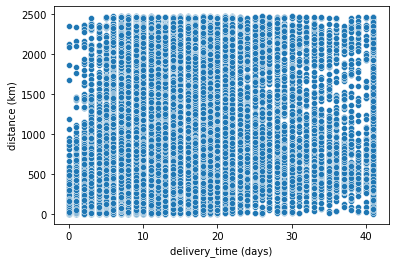

In [102]:
sns.scatterplot(x = figure_5["delivery_time (days)"], y = figure_5["distance (km)"])
plt.show()

Now, the values are not too far from each other, but the points on the scatter plot be overlapping so we can't see how the correlation of the data. Hence, we have to measure the correlation between *distance (km)* and *delivery_time (days)*.

In [103]:
corr_figure_5 = figure_5[["delivery_time (days)","distance (km)"]].corr()

The correlation is visualized below:

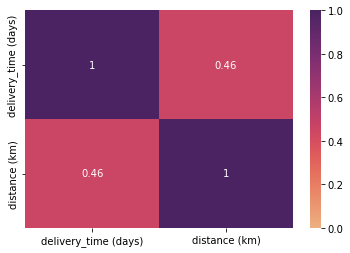

In [104]:
# plot the data correlation
sns.heatmap(corr_figure_5, annot = True, cmap = "flare", vmin = 0, vmax = 1)

# format y-axis
plt.yticks(va = "center")

plt.show()

Based on the figure above, the coefficient correlation between *distance (km)* and *delivery_time (days)* is 0.46, which means the two variables have a moderate correlation.